### Simple Credit Scoring Example

### 1. Load libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer

from sklearn.metrics import matthews_corrcoef, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV, StratifiedShuffleSplit, cross_validate

from scipy.stats import uniform
from sklearn.pipeline import Pipeline

# for a convenient display of dataframes
pd.set_option("display.max_columns", None)

%matplotlib inline

In [2]:
data = pd.read_csv("cs-training.csv", index_col=0)

### 2. Explore our datasets

#### 2.1 Summary Statistics

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [4]:
data.head(3)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0


look at data distributions

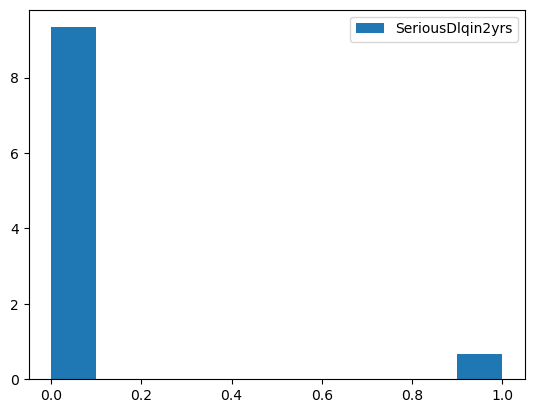

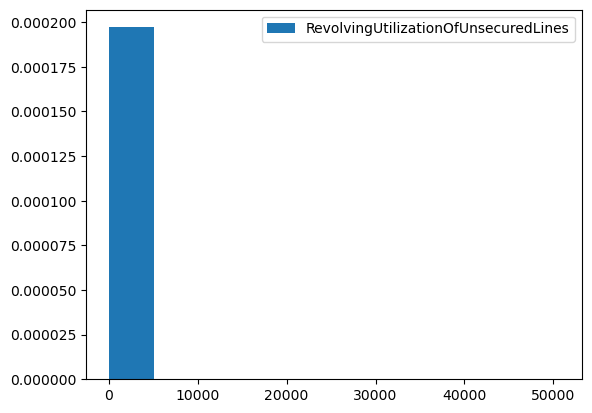

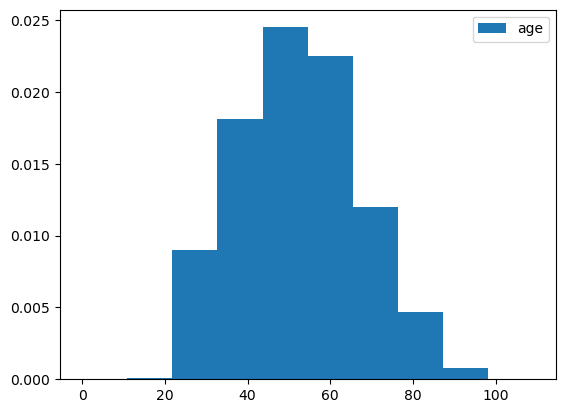

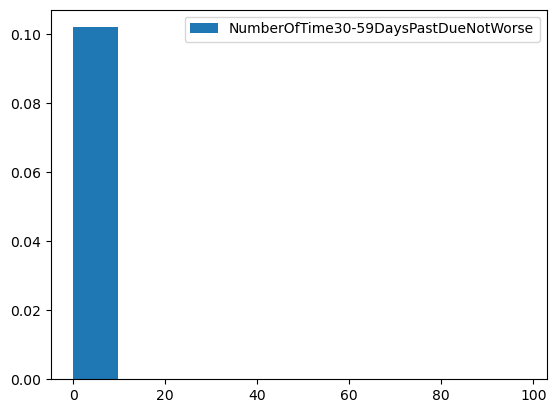

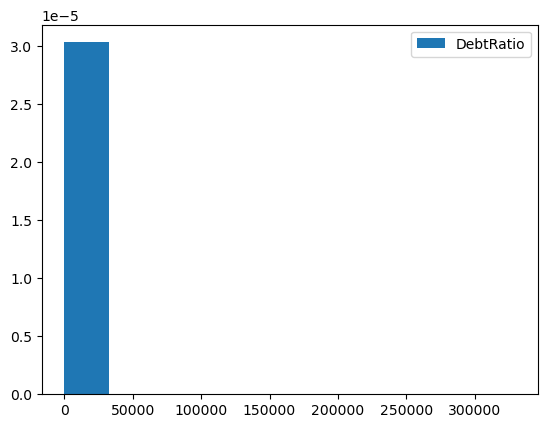

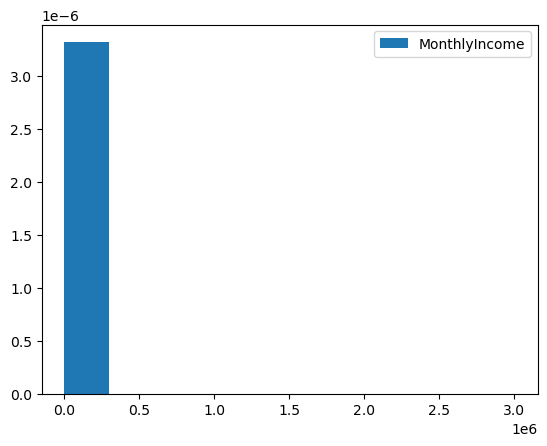

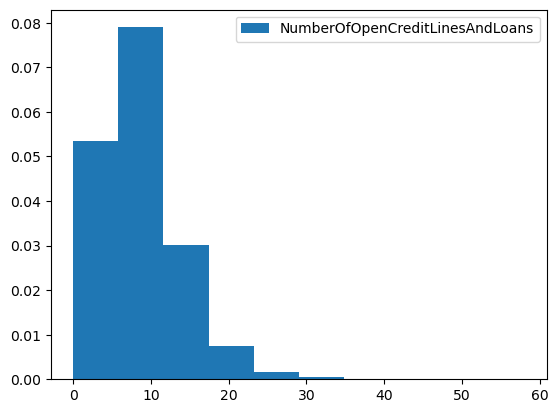

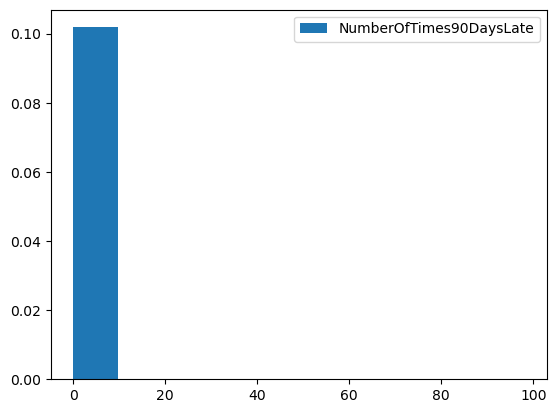

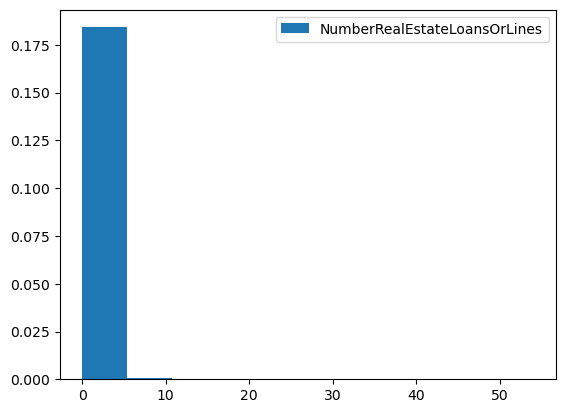

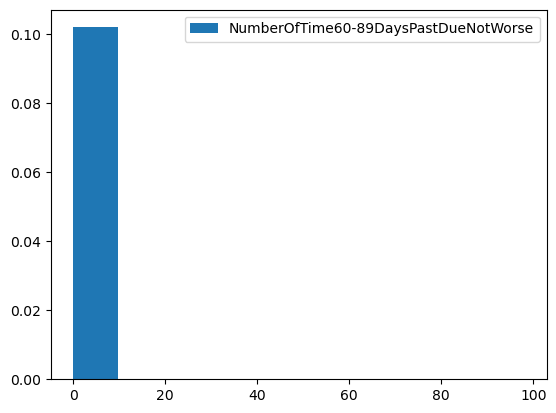

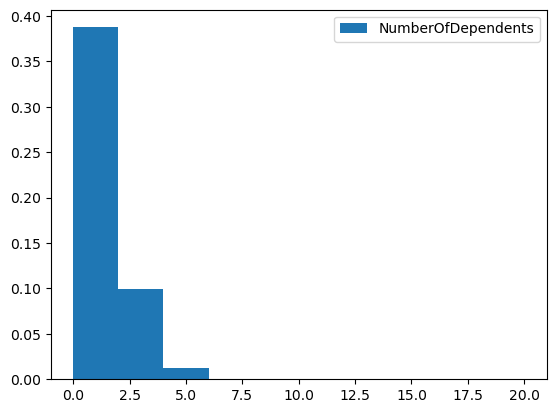

In [5]:
for column in data.columns:
    plt.hist(data[column], label=column, density=True)
    plt.legend()
    plt.show()

### 3. Split the data for train and test

In [6]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(y=data.SeriousDlqin2yrs, X=data.iloc[:, 1:]):
    X_train = data.iloc[train_index, :].reset_index(drop=True)
    X_test = data.iloc[test_index, :].reset_index(drop=True)

In [7]:
y_train, y_test = X_train.SeriousDlqin2yrs, X_test.SeriousDlqin2yrs
del X_train["SeriousDlqin2yrs"]
del X_test["SeriousDlqin2yrs"]

### 4. Cross-validation for parameters tuning and model selection

for simplicity show below only tuning of LogisticRegression and cross-validate other model out of the box

In [13]:
log_reg = LogisticRegression(solver="saga", max_iter=150, tol=1e-2)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
log_reg_pipe = Pipeline([("imputer", SimpleImputer()), ("model", log_reg)])
distributions = dict(
    model__C=uniform(loc=0, scale=10),
    model__penalty=["l2", "l1"],
    model__class_weight=["balanced", None]
)
log_reg_rs = RandomizedSearchCV(
    estimator=log_reg_pipe, 
    param_distributions=distributions, 
    random_state=0, 
    cv=cv, 
    n_iter=30, 
    n_jobs=-1,
    scoring="roc_auc"
)
log_reg_rs.fit(X_train, y_train)
print(log_reg_rs)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('model',
                                              LogisticRegression(max_iter=150,
                                                                 solver='saga',
                                                                 tol=0.01))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'model__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fc68086d2a0>,
                                        'model__class_weight': ['balanced',
                                                                None],
                                        'model__penalty': ['l2', 'l1']},
                   random_state=0, scoring=make_scorer(matthews_corrcoef))


In [9]:
rf_pipe = Pipeline([("imputer", SimpleImputer()), ("model", RandomForestClassifier())])
rf_results = cross_validate(rf_pipe, X_train, y_train, scoring=make_scorer(matthews_corrcoef), cv=5, n_jobs=-1)

In [22]:
### check our luck
rf_results["test_score"].mean(), log_reg_rs.best_score_

(0.3023999640847693, 0.0045644138221754265)

Definitely the RandomForest model have a best result

### 5. Evaluate model with test data

In [19]:
rf_pipe.fit(X_train, y_train)
print(rf_pipe)

Pipeline(steps=[('imputer', SimpleImputer()),
                ('model', RandomForestClassifier())])


In [20]:
roc_auc_score(y_score=rf_pipe.predict_proba(X_test)[:, 1], y_true=y_test)

0.8451813491810747

### 6. Bentoml Deployment

In [24]:
import bentoml

In [25]:
bentoml.sklearn.save_model(
    "scoring_model",
    rf_pipe
)

Model(tag="scoring_model:5pslzte5ucmnzuan", path="/home/nenomius/bentoml/models/scoring_model/5pslzte5ucmnzuan/")

In [29]:
### check the saved model
rf_scorer = bentoml.sklearn.load_model("scoring_model:latest")

In [30]:
rf_scorer.predict_proba(X_test.iloc[:2, :])

/home/nenomius/miniconda3/envs/main/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


array([[1.  , 0.  ],
       [0.28, 0.72]])